In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV filSinglee I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
torch.__version__

'2.1.2'

In [3]:
torch.cuda.is_available()

True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
import warnings
warnings.filterwarnings("ignore")


In [6]:
import gc
import random
import numpy as np
import pandas as pd
from IPython.display import display

In [7]:
# pytorch modules
import timm # to load the torch image processing models, will use resnrt34
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms

gc.collect()

16

In [8]:
class Config:
    seed = 42
    image_transform = transforms.Resize((214, 214)) # resent34's input size
    batch_size = 16
    num_epochs = 10

# Reproducibility

In [9]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.manual_seed(Config.seed)
np.random.seed(Config.seed)
random.seed(Config.seed)

# load train.csv

In [10]:
train_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
train_df.head()

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   
2       42516          Seizure             3         0         0          0   
3       42516          Seizure             3         0         0          0   
4       42516          Seizure             3         0         0          0   

   grda_vote  other_vote  
0          0           0  
1          0           0  
2          0           0  
3          0           0  
4          0           0

In [11]:
train_df.shape

(106800, 15)

In [12]:
train_df.spectrogram_id.nunique()

11138

# we have 6 classes

In [13]:
labels = [label.lower() for label in train_df.expert_consensus.unique()]
labels

['seizure', 'gpd', 'lrda', 'other', 'grda', 'lpd']

# output is a probability distribution so we need to create our label and normalize it so that it can be used for loss function

In [14]:
target_df = pd.DataFrame()
for label in labels:
    grouped_by_spec = train_df[f"{label}_vote"].groupby(train_df.spectrogram_id).sum()
    temp_grouped_df = pd.DataFrame({"spectrogram_id" : grouped_by_spec.index,
                                    f"{label}_vote_sum" : grouped_by_spec.values})
    
    # first label will become df, rest will merge
    if label == "seizure":
        target_df = temp_grouped_df
    else:
        target_df = target_df.merge(temp_grouped_df, on = "spectrogram_id", how = "left")

In [15]:
target_df.head()

spectrogram_id  seizure_vote_sum  gpd_vote_sum  lrda_vote_sum  \
0          353733                27             0              0   
1          924234                 0            10              0   
2          999431                 0             0            154   
3         1084844                 0             0             18   
4         1219001                21            10              0   

   other_vote_sum  grda_vote_sum  lpd_vote_sum  
0               0              0             0  
1              10              2             0  
2              11              0            11  
3               0              0             0  
4               0              0             0

we will have same shape as number of unique spectogram IDs

In [16]:
target_df.shape[0] == train_df.spectrogram_id.nunique()

True

In [17]:
# normalize
target_df["total_vote"] = 0
for label in labels:
    target_df["total_vote"] += target_df[f"{label}_vote_sum"]
target_df.head()

spectrogram_id  seizure_vote_sum  gpd_vote_sum  lrda_vote_sum  \
0          353733                27             0              0   
1          924234                 0            10              0   
2          999431                 0             0            154   
3         1084844                 0             0             18   
4         1219001                21            10              0   

   other_vote_sum  grda_vote_sum  lpd_vote_sum  total_vote  
0               0              0             0          27  
1              10              2             0          22  
2              11              0            11         176  
3               0              0             0          18  
4               0              0             0          31

In [18]:
for label in labels:
    target_df[f"{label}_vote_sum"] = target_df[f"{label}_vote_sum"]/target_df.total_vote
    
target_df = target_df.drop("total_vote", axis = 1)
target_df.head()

spectrogram_id  seizure_vote_sum  gpd_vote_sum  lrda_vote_sum  \
0          353733          1.000000      0.000000          0.000   
1          924234          0.000000      0.454545          0.000   
2          999431          0.000000      0.000000          0.875   
3         1084844          0.000000      0.000000          1.000   
4         1219001          0.677419      0.322581          0.000   

   other_vote_sum  grda_vote_sum  lpd_vote_sum  
0        0.000000       0.000000        0.0000  
1        0.454545       0.090909        0.0000  
2        0.062500       0.000000        0.0625  
3        0.000000       0.000000        0.0000  
4        0.000000       0.000000        0.0000

# adding paths to spectrogram files

In [19]:
target_df["path"] = target_df["spectrogram_id"].apply(lambda x: "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/" + str(x) + ".parquet")
target_df.head()

spectrogram_id  seizure_vote_sum  gpd_vote_sum  lrda_vote_sum  \
0          353733          1.000000      0.000000          0.000   
1          924234          0.000000      0.454545          0.000   
2          999431          0.000000      0.000000          0.875   
3         1084844          0.000000      0.000000          1.000   
4         1219001          0.677419      0.322581          0.000   

   other_vote_sum  grda_vote_sum  lpd_vote_sum  \
0        0.000000       0.000000        0.0000   
1        0.454545       0.090909        0.0000   
2        0.062500       0.000000        0.0625   
3        0.000000       0.000000        0.0000   
4        0.000000       0.000000        0.0000   

                                                path  
0  /kaggle/input/hms-harmful-brain-activity-class...  
1  /kaggle/input/hms-harmful-brain-activity-class...  
2  /kaggle/input/hms-harmful-brain-activity-class...  
3  /kaggle/input/hms-harmful-brain-activity-class...  
4  /kaggle/input/hms-harmful-brain-activity-class...

In [20]:
pd.read_parquet(target_df["path"][0]).head()

time  LL_0.59  LL_0.78  LL_0.98  LL_1.17  LL_1.37    LL_1.56    LL_1.76  \
0     1     4.26    10.98     9.05    13.65    11.49   8.930000  18.840000   
1     3     2.65     3.97    12.18    13.26    14.21  13.230000   9.650000   
2     5     4.18     4.53     8.77    14.26    13.36  16.559999  19.219999   
3     7     2.41     3.21     4.92     8.07     5.97  12.420000  10.820000   
4     9     2.29     2.44     2.77     4.62     5.39   7.080000   9.840000   

   LL_1.95    LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  RP_18.95  \
0    19.26  19.240000  ...      0.31      0.17      0.28      0.19      0.24   
1     8.11  11.280000  ...      0.15      0.13      0.14      0.24      0.24   
2    17.51  22.650000  ...      0.29      0.21      0.16      0.25      0.28   
3    14.96  21.809999  ...      0.33      0.51      0.49      0.64      0.58   
4    12.27  14.410000  ...      0.44      0.38      0.48      0.63      0.45   

   RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92  
0      0.27      0.29      0.16      0.22      0.19  
1      0.36      0.35      0.31      0.36      0.40  
2      0.28      0.34      0.48      0.44      0.48  
3      0.42      0.32      0.31      0.32      0.33  
4      0.45      0.49      0.33      0.31      0.34  

[5 rows x 401 columns]

# visualize the spectrogram

reference : https://www.kaggle.com/code/clehmann10/plot-spectrograms

In [21]:
import matplotlib.pyplot as plt 
def plot_spectogram(path):
    target = pd.read_parquet(path)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    
    target = {
        "LL": target.filter(regex='^LL', axis=1),
        "RL": target.filter(regex='^RL', axis=1),
        "RP": target.filter(regex='^RP', axis=1),
        "LP": target.filter(regex='^LP', axis=1)}
    
    #print(target["LL"].head())
    
    for i, label in enumerate(target.keys()):
        # select the subplot
        ax = axes[i]
        # plot the class columns
        """
            In the context of plotting spectrogram data, where the columns represent 
            different time points and the rows represent different frequency bins, 
            transposing the DataFrame allows to correctly align the time and frequency 
            axes with the axes of the plot.
            This adjustment is often necessary because the default orientation of 
            imshow() considers the first axis (axis 0) as the vertical axis and 
            the second axis (axis 1) as the horizontal axis.
        """
        img = ax.imshow(np.log(target[label]).T, cmap='viridis', aspect='auto', origin='lower')
                        
    plt.tight_layout()
    plt.show()

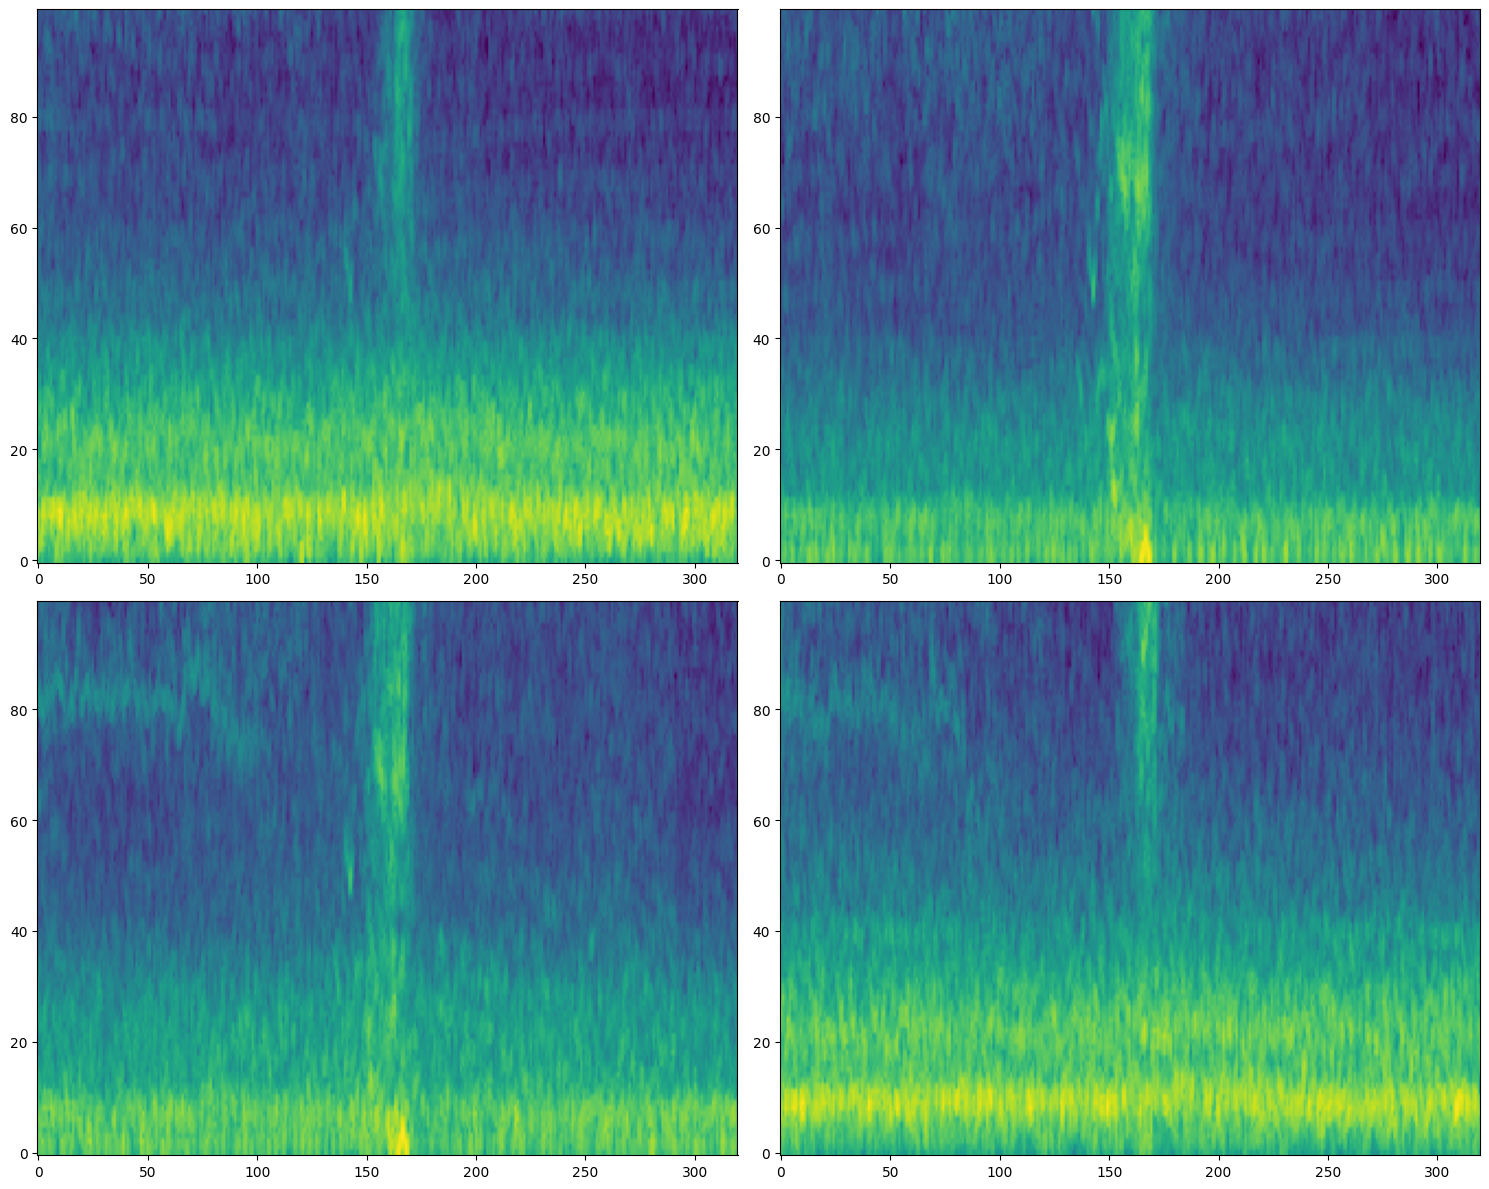

In [22]:
plot_spectogram(target_df["path"][0])

# testing paths

In [23]:
target_df[["path"]].iloc[0].values

array(['/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/353733.parquet'],
      dtype=object)

In [24]:
target_df["path"].iloc[0]

'/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/353733.parquet'

In [25]:
def get_data(paths):
    eps = 1e-6 # incase data_std returns 0
    batch_data = []
    for path in paths:
        data = pd.read_parquet(path[0])
        data = data.fillna(-1).values[:, 1:].T
        data = np.clip(data, np.exp(-6), np.exp(10)) # avioid log(0)
        data = np.log(data)
        
        data_mean = data.mean(axis=(0, 1))
        data_std = data.std(axis=(0, 1))
        data = (data - data_mean) / (data_std + eps)
        
        data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
        data = Config.image_transform(data_tensor)
        
        batch_data.append(data)
        
    return torch.stack(batch_data)

# Loss function - KL Divergence
As all the other losses in PyTorch, this function expects the first argument, input, to be the output of the model (e.g. the neural network) and the second, target, to be the observations in the dataset. This differs from the standard mathematical notation KL(P ∣∣ Q) where P denotes the distribution of the observations and Q denotes the model.

**P and Q collected from first batch for testing -**

In [26]:
from torch import tensor
q = tensor([[-1.6940, -2.1301, -1.5520, -1.8284, -2.0036, -1.6604],
        [-1.9642, -1.7419, -1.8139, -2.3096, -1.3975, -1.7428],
        [-2.1160, -2.1227, -1.3230, -2.3438, -1.7481, -1.4988],
        [-1.4986, -1.9374, -1.9222, -2.3122, -1.6053, -1.6803],
        [-1.8341, -1.9532, -1.4860, -2.3468, -1.6309, -1.7107],
        [-1.6563, -2.0311, -1.4867, -2.4550, -1.7540, -1.6456],
        [-1.5836, -2.3408, -1.8777, -2.2978, -1.5743, -1.4357],
        [-1.6916, -2.1199, -1.4975, -2.4277, -1.5535, -1.7586],
        [-1.5585, -2.0798, -1.7232, -2.0947, -1.9084, -1.5387],
        [-1.9217, -2.1057, -1.5207, -2.4002, -1.5469, -1.5620],
        [-1.9007, -2.0794, -1.3917, -2.5418, -1.4974, -1.7462],
        [-1.4677, -2.1244, -1.7871, -2.3519, -1.5373, -1.7577],
        [-1.7461, -2.0305, -1.6301, -2.2001, -1.6929, -1.5916],
        [-1.8966, -1.9698, -1.7667, -2.0065, -1.5853, -1.6085],
        [-1.7947, -1.9670, -1.3701, -2.4688, -1.7262, -1.7303],
        [-1.6341, -2.1774, -1.7342, -2.2786, -1.5699, -1.5872]])
p = tensor([[0.0079, 0.0794, 0.0000, 0.4206, 0.0317, 0.4603],
        [0.0000, 0.0000, 0.2308, 0.0000, 0.3846, 0.3846],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.3878, 0.0000, 0.0204, 0.0918, 0.5000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0556, 0.3333, 0.0000, 0.0556, 0.5556],
        [0.0128, 0.0000, 0.0128, 0.0513, 0.0128, 0.9103],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.8000, 0.0000, 0.0667, 0.1333]])

reference - https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html

reduction="batchmean" means that the loss for each individual sample in the batch will be computed, and then the average of these losses will be taken as the final loss.

In [27]:
from torch import tensor
from torchmetrics.regression import KLDivergence
p_single = tensor([[0.36, 0.48, 0.16]])
q_single = tensor([[1/3, 1/3, 1/3]])
kl_divergence = KLDivergence()
kl_divergence(p_single, q_single)

tensor(0.0853)

In [28]:
kl_divergence(q, p), kl_divergence(p, q)

(tensor(inf), tensor(1.5082))

- trying log_softmax for both p and q
- use nn.KLDivLoss() from torch

In [29]:
# DOES NOT WORK FOR TRAINING
def soft_kl_divergence(input, target):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    # input, target should be a distribution in the log space
    input = F.log_softmax(input, dim=1)
    target = F.log_softmax(target, dim=1)

    return kl_loss(input, target)

soft_kl_divergence(q, p), soft_kl_divergence(p, q)

(tensor(nan), tensor(nan))

- use epsilon 1e-6 so that we dont have log(0) and not dividing by 0
- using log_softmax
- using default nn.KLDivLoss() from torch


In [30]:
# DOES NOT WORK FOR TRAINING
def soft_kl_divergence(input, target, epsilon=1e-6):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    
    input_log_softmax = F.log_softmax(input + epsilon, dim=1)
    
    target_softmax = F.softmax(target, dim=1)
    # add epsilon to avoid zero division
    target_softmax = target_softmax / (target_softmax.sum(dim=1, keepdim=True) + epsilon)
    # add epsilon to avoid taking log(0)
    target_log_softmax = F.log_softmax(target_softmax + epsilon, dim=1)  
    
    # debug
#     print("Input:", input)
#     print("Target:", target)
#     print("Input (log_softmax):", input_log_softmax)
#     print("Target (log_softmax):", target_log_softmax)
    
    return kl_loss(input_log_softmax, target_log_softmax)

soft_kl_divergence(q, p), soft_kl_divergence(p, q)

(tensor(nan), tensor(nan))

In [31]:
def soft_kl_divergence(input, target, epsilon=1e-6):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    
    input_softmax = F.softmax(input+epsilon, dim=1)
    
    target_softmax = F.softmax(target+epsilon, dim=1)
    
    # debug
#     print("Input:", input)
#     print("Target:", target)
#     print("Input (log_softmax):", input_log_softmax)
#     print("Target (log_softmax):", target_log_softmax)
    
    return kl_loss(input_softmax, target_softmax)

soft_kl_divergence(q, p), soft_kl_divergence(p, q)

(tensor(-1.8837), tensor(-1.9209))

- trying epsilon
- softmax
- just compute kl divergence using formula

In [32]:
def soft_kl_divergence(p, q, epsilon=1e-6):
    # no log(0)
    p_softmax = F.softmax(p + epsilon, dim=1)
    
    q_softmax = F.softmax(q + epsilon, dim=1)
    
    # calculate kl divergence manually
    kl_loss = torch.mean(torch.sum(p_softmax * (torch.log(p_softmax) - torch.log(q_softmax)), dim=1))
    
    return kl_loss

soft_kl_divergence(q, p), soft_kl_divergence(p, q)

(tensor(0.0967), tensor(0.1063))

# training

following https://www.kaggle.com/code/andreasbis/hms-train-resnet34d/notebook

In [33]:
    model = timm.create_model('resnet34d', pretrained=True, num_classes=6, in_chans=1)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.5, 0.999), weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=Config.num_epochs)

    best_test_loss = float('inf')
    train_losses = []
    test_losses = []

model.safetensors:   0%|          | 0.00/87.4M [00:00<?, ?B/s]

In [34]:
train_idx = np.arange(int(len(target_df)* 0.8))
np.random.shuffle(train_idx)

In [35]:
train_idx, train_idx.shape

(array([4575, 1488, 4970, ..., 5390,  860, 7270]), (8910,))

In [36]:
y_features = ["seizure_vote_sum", 
              "lpd_vote_sum", 
              "gpd_vote_sum", 
              "lrda_vote_sum", 
              "grda_vote_sum", 
              "other_vote_sum"]

In [37]:
from torchvision.transforms.functional import to_pil_image

def show_resized(resized_tensor):
    # Convert the resized tensor to a PIL Image
    resized_image = to_pil_image(resized_tensor)

    # Display the resized image
    resized_image.show()

In [38]:
 for epoch in range(Config.num_epochs):
        print(f"Epoch - {epoch}")
        model.train()
        train_loss = []
        train_loss_plot = []

        # get one batch at a time
        for idx in range(0, len(train_idx), Config.batch_size):
#             print(idx, end = "-")
            optimizer.zero_grad()
    
            train_idx1 = train_idx[idx:idx + Config.batch_size]
            train_X1_path = target_df[["path"]].iloc[train_idx1].values
            train_X1 = get_data(train_X1_path)
            print(train_X1.shape)
#             print(f"train values from function {train_X1}")
            
            train_y1 = target_df[y_features].iloc[train_idx1].values
            train_y1 = torch.Tensor(train_y1)
#             print(f"y values for probability {train_y1}")

            train_pred = model(train_X1.to(device))
#             print(f"train pred {train_pred}")
            
#             loss = KL_loss(train_y1.to(device), train_pred)
#             loss = kl_divergence(train_y1.to(device), train_pred)

            loss = soft_kl_divergence(train_pred, train_y1.to(device))
#             print(f"loss value in tensor {loss}")

            loss.backward()
    
            optimizer.step()
            train_loss.append(loss.item())
            print(f"loss item {loss.item()}")
            
            break
        break

        epoch_train_loss = np.mean(train_loss)
        print(f"mean loss in the epoch {epoch_train_loss}")
        train_loss_plot.append(epoch_train_loss)
        print(f"Epoch {epoch + 1}: Train Loss = {epoch_train_loss:.2f}")

        scheduler.step()

gc.collect()

Epoch - 0
torch.Size([16, 1, 214, 214])
loss item 0.09666333347558975


12678

In [39]:
train_X1[0].shape

torch.Size([1, 214, 214])

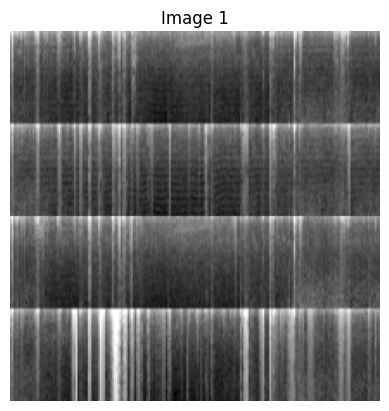

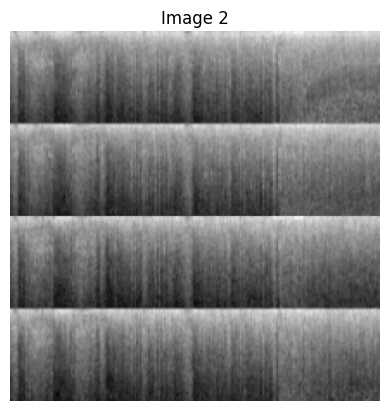

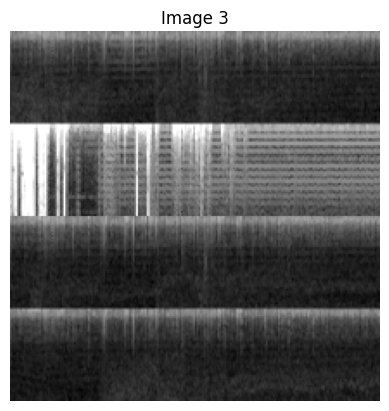

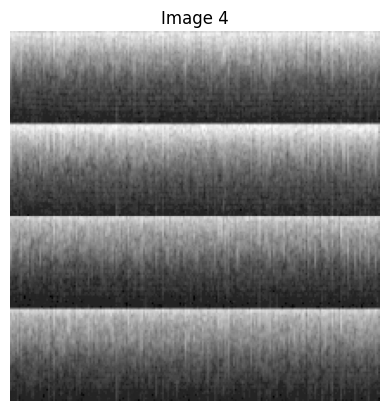

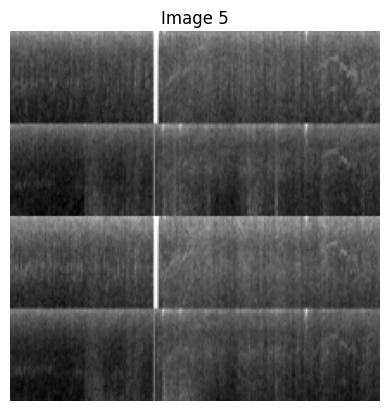

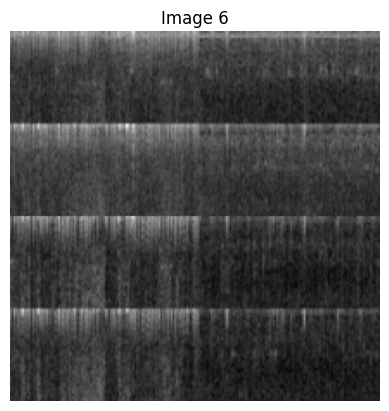

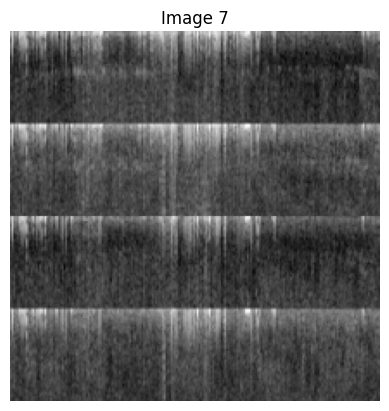

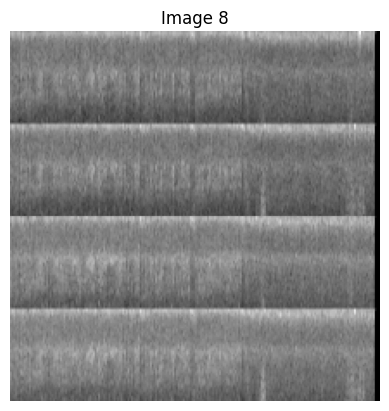

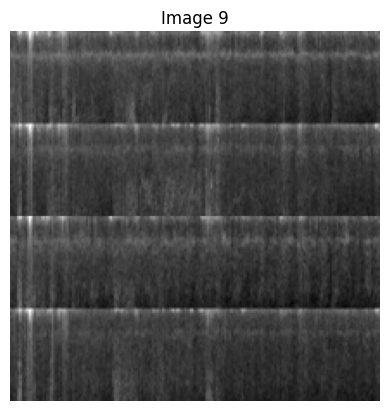

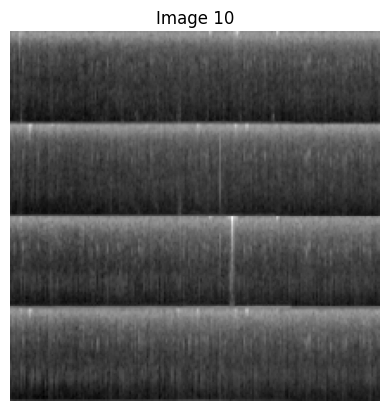

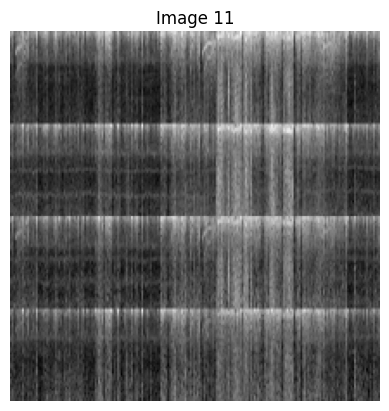

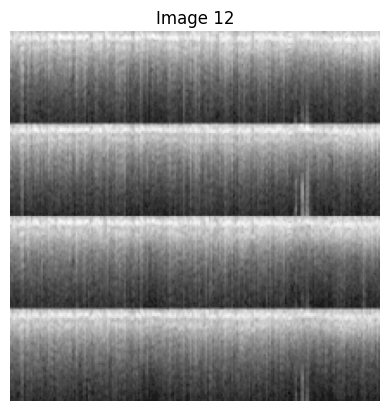

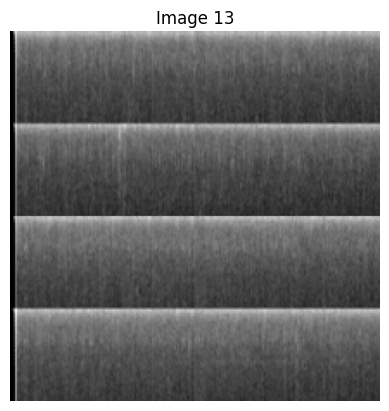

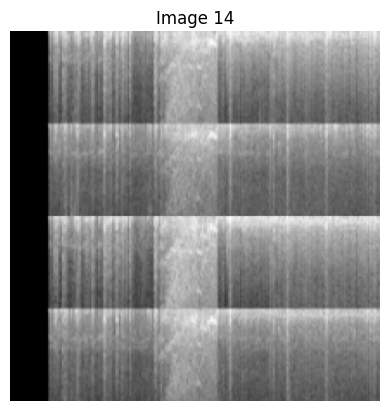

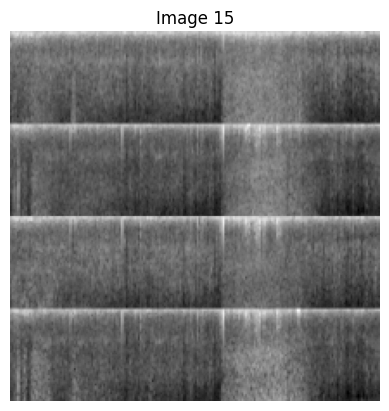

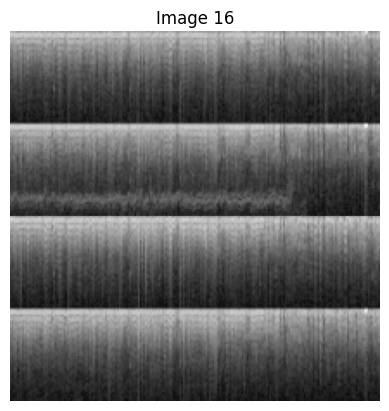

In [40]:
import matplotlib.pyplot as plt
import torch

# Iterate over each tensor in the stack
for i in range(train_X1.shape[0]):
    # Access the i-th tensor in the stack
    tensor_i = train_X1[i]

    # Convert the tensor to a numpy array and then to an image
    image_i = tensor_i.squeeze().numpy()  # Remove the single channel dimension

    # Plot the image
    plt.imshow(image_i, cmap='gray')  # Assuming grayscale images
    plt.title(f"Image {i+1}")  # Set a title for the image
    plt.axis('off')  # Hide the axes
    plt.show()  # Display the image


In [41]:
import torch

# Assuming train_X1 has shape [16, 1, 214, 214]
# Convert grayscale images to RGB by duplicating the single channel
train_X1_rgb = torch.cat([train_X1, train_X1, train_X1], dim=1)

# Now train_X1_rgb has shape [16, 3, 214, 214], indicating 16 RGB images
train_X1_rgb.shape

torch.Size([16, 3, 214, 214])

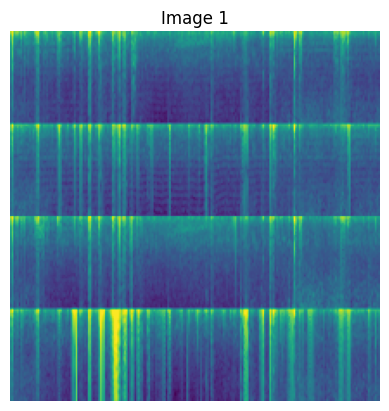

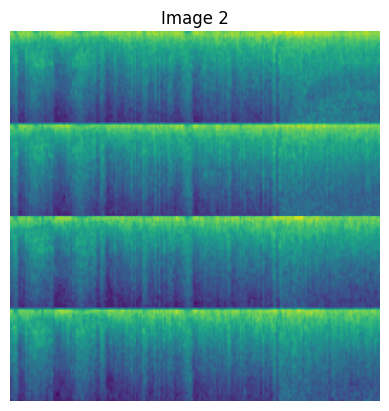

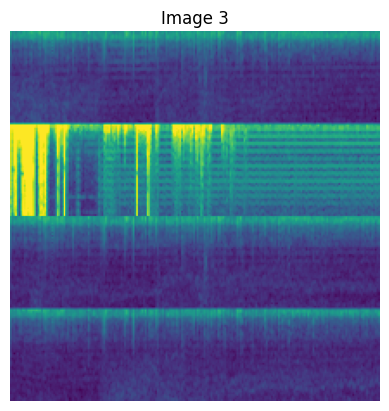

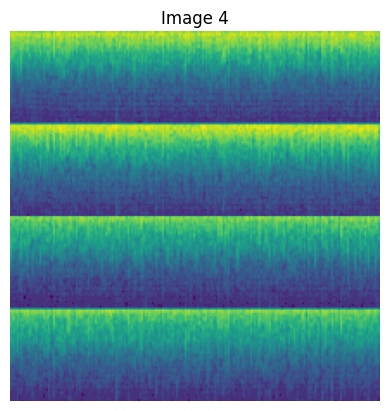

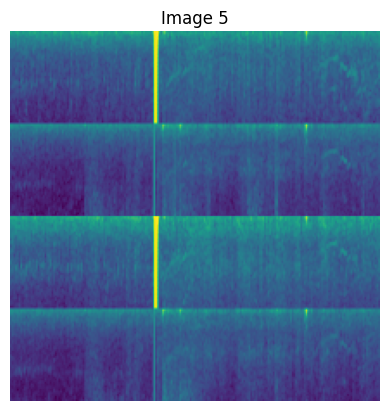

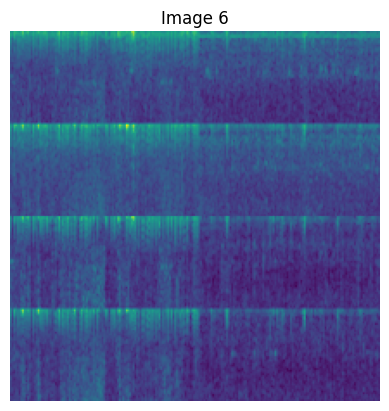

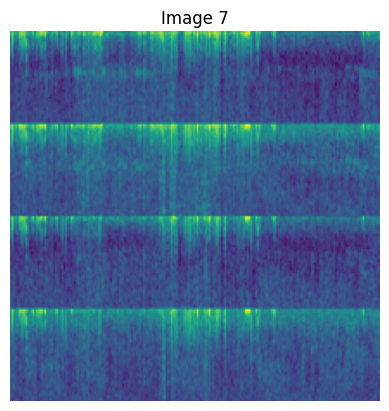

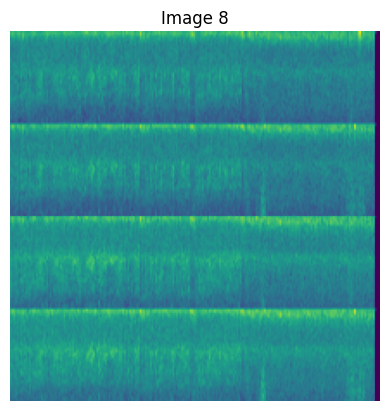

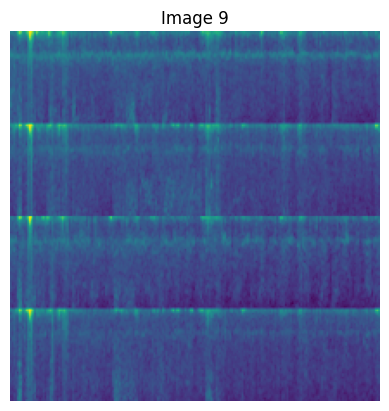

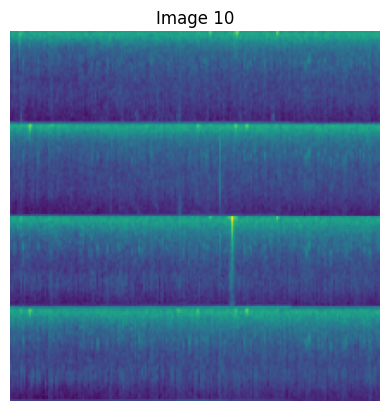

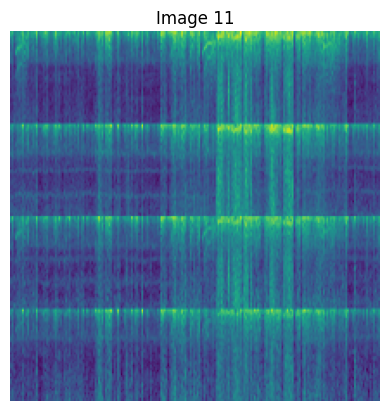

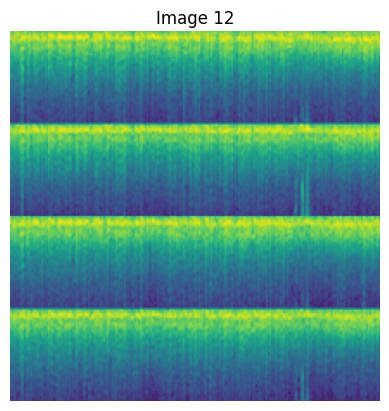

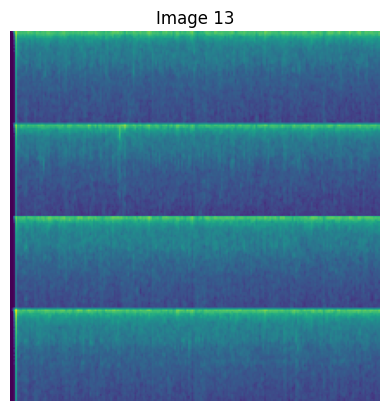

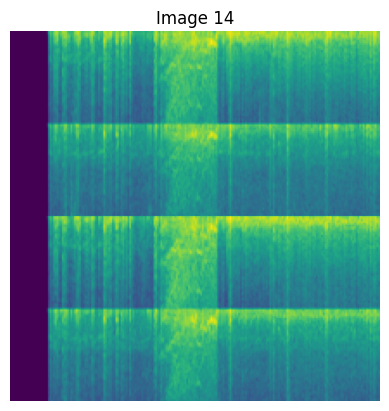

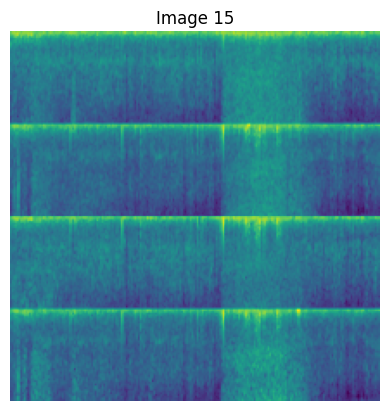

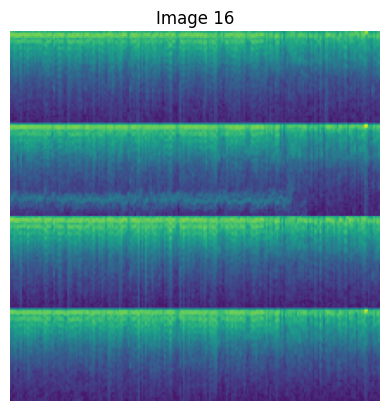

In [42]:
for i in range(train_X1_rgb.shape[0]):
    # Access the i-th tensor in the stack
    tensor_i = train_X1[i]

    # Convert the tensor to a numpy array and then to an image
    image_i = tensor_i.squeeze().numpy()  # Remove the single channel dimension

    # Plot the image
    plt.imshow(image_i, cmap='viridis')  # Assuming grayscale images
    plt.title(f"Image {i+1}")  # Set a title for the image
    plt.axis('off')  # Hide the axes
    plt.show()  # Display the image
